# Main EDA notebook

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from datetime import datetime as dt
import re
import random

pd.options.mode.chained_assignment = None  

In [121]:
# Notes
# TODO optimalise generate data
# do timeseries

In [1]:
zuzycie01_raw = pd.read_excel("data/01zuzycie.xlsx")
zbiorniki02_raw = pd.read_excel("data/02zbiorniki.xlsx")
liczniki03_raw = pd.read_excel("data/03liczniki.xlsx")
firmy04_raw = pd.read_excel("data/04firmy.xlsx")
osoby05_raw = pd.read_excel("data/05osoby.xlsx")
deklarowane06_raw = pd.read_excel("data/06deklarowane.xlsx")

NameError: name 'pd' is not defined

In [123]:
# zmiana nazw kolumn
zuzycie01 = zuzycie01_raw.drop(['Lp.'], axis = 1)
c = zuzycie01.columns
zuzycie01 = zuzycie01.rename(columns = {c[0]: 'nr_licznika',
                                        c[1]: 'osoba',
                                        c[2]: 'adres_licznika',
                                        c[3]: 'zuzycie_wody',
                                        c[4]: 'srednie_zuzucie_wody'})
for i in range(5, len(c)):
    zuzycie01.rename(columns = {c[i]: str(i)})

                     
zbiorniki02 = zbiorniki02_raw.drop(['Lp.'], axis = 1)
c = zbiorniki02.columns
zbiorniki02 = zbiorniki02.rename(columns = {c[0]: 'nr_zbiornika',
                              c[1]: 'osoba',
                              c[2]: 'adres_licznika',
                              c[3]: 'adres_zamieszkania'})

liczniki03 = liczniki03_raw.drop(['Lp.'], axis = 1)
c = liczniki03.columns
liczniki03 = liczniki03.rename(columns = {c[0]: 'nr_licznika',
                                          c[1]: 'osoba',
                                          c[2]: 'adres_licznika',
                                          c[3]: 'adres_zamieszkania'})

firmy04 = firmy04_raw.drop(['Lp.'], axis = 1)
c = firmy04.columns
firmy04 = firmy04.rename(columns = {c[0]: 'nr_koncesji',
                              c[1]: 'nazwa_firmy',
                              c[2]: 'adres_firmy',
                              c[3]: 'nr_pojazdu',
                              c[4]: 'pojemnosc_pojazdu'})

osoby05 = osoby05_raw.drop(['Lp.'], axis = 1)
c = osoby05.columns
osoby05 = osoby05.rename(columns = {c[0]: 'nr_zbiornika',
                              c[1]: 'adres_licznika',
                              c[2]: 'liczba_osob_zameldowanych',
                              c[3]: 'liczba_osob_smieci'})

deklarowane06 = deklarowane06_raw.drop(['Lp.'], axis = 1)
c = deklarowane06.columns
deklarowane06 = deklarowane06.rename(columns = {c[0]: 'nr_zbiornika',
                                                c[1]: 'adres_licznika',
                                                c[2]: 'data_odbioru',
                                                c[3]: 'deklaracja_mieszkaniec',
                                                c[4]: 'deklaracja_firma',
                                                c[5]: 'pobrana_woda',
                                                c[6]: 'pobrana_woda_ogrodowa',
                                                c[7]: 'nr_pojazdu'})



In [125]:
# wyliczenie liczby osób jako średniej z zameldowanych i bazy śmieciowej
# i wyrzucenie tych kolumn
osoby05['liczba_osob'] = (osoby05['liczba_osob_zameldowanych'] + osoby05['liczba_osob_smieci'])/2
osoby05 = osoby05.drop(['liczba_osob_zameldowanych', 'liczba_osob_smieci', 'nr_zbiornika'], axis = 1)

# czyszczenie deklarowanych
deklarowane06 = deklarowane06.drop(['pobrana_woda_ogrodowa', 'nr_zbiornika'], axis = 1)

In [126]:
# Łączenie tabel i usuwanie niepotrzebnych kolumn


liczniki_zbiorniki = zbiorniki02.set_index(['adres_licznika', 'osoba', 'adres_zamieszkania'])\
                    .join(liczniki03.set_index(['adres_licznika', 'osoba', 'adres_zamieszkania']))\
                    .reset_index()

# drop kolumn adres zamieszkania skoro wszedzie jest taki sam jak adres licznika
liczniki_zbiorniki = liczniki_zbiorniki.drop(['adres_zamieszkania', 'nr_zbiornika'], axis = 1)

liczniki_z_osobami = liczniki_zbiorniki.set_index(['adres_licznika'])\
                    .join(osoby05.set_index(['adres_licznika']))\
                    .reset_index()

licz_os_deklaracje = liczniki_z_osobami.set_index(['adres_licznika'])\
                    .join(deklarowane06.set_index(['adres_licznika']))\
                    .reset_index()

licz_os_dekl_pojaz = licz_os_deklaracje.set_index(['nr_pojazdu'])\
                    .join(firmy04.set_index(['nr_pojazdu']))\
                    .reset_index()

dane_koncowe = licz_os_dekl_pojaz.set_index(['nr_licznika', 'osoba', 'adres_licznika'])\
                    .join(zuzycie01.set_index(['nr_licznika', 'osoba', 'adres_licznika']))\
                    .reset_index()


In [128]:
# drop some usless columns
df = licz_os_dekl_pojaz.drop(['osoba', 
                              'nr_licznika', 'nr_koncesji', 
                              'nazwa_firmy', 'adres_firmy',
                              'data_odbioru'], axis = 1)

In [129]:
df['pobrana_woda'] = dane_koncowe['srednie_zuzucie_wody']

In [130]:
df.head()

,nr_pojazdu,adres_licznika,liczba_osob,deklaracja_mieszkaniec,deklaracja_firma,pobrana_woda,pojemnosc_pojazdu
0,PGN 415KA,Zamiejska 16,3.5,4.0,4.0,10.428971,18.0
1,PGN 415KA,Kłeckoska 87,5.5,15.0,14.0,20.712486,18.0
2,PGN 415KA,Trzemeszeńska 7,4.0,9.0,9.0,10.142857,18.0
3,PGN 415KA,Kłeckoska 18,3.0,10.0,9.0,9.078114,18.0
4,PGN 415KA,Roosevelta 9,5.0,10.0,9.0,15.371429,18.0


# Analiza bez miesięcznych pobrań i adresów

In [131]:
# drop that is controversial - experimental
df_bez_zbiornikow = df.drop(['adres_licznika'], axis = 1)

In [132]:
df_bez_zbiornikow.head()

,nr_pojazdu,liczba_osob,deklaracja_mieszkaniec,deklaracja_firma,pobrana_woda,pojemnosc_pojazdu
0,PGN 415KA,3.5,4.0,4.0,10.428971,18.0
1,PGN 415KA,5.5,15.0,14.0,20.712486,18.0
2,PGN 415KA,4.0,9.0,9.0,10.142857,18.0
3,PGN 415KA,3.0,10.0,9.0,9.078114,18.0
4,PGN 415KA,5.0,10.0,9.0,15.371429,18.0


In [133]:
df_bez_zbiornikow['st_oddanej_do_pobranej'] = (df_bez_zbiornikow['deklaracja_mieszkaniec'] + 
                                                df_bez_zbiornikow['deklaracja_firma'])/2 / \
                                                df_bez_zbiornikow['pobrana_woda']

In [134]:
df_bez_zbiornikow['deficyt_litrow'] = df_bez_zbiornikow['pobrana_woda'] - \
                                    (df_bez_zbiornikow['deklaracja_mieszkaniec'] + \
                                    df_bez_zbiornikow['deklaracja_firma'])/2 
                                                

In [135]:
# get dummy variables for licz_os_dekl
df_bez_zbiornikow = pd.get_dummies(df_bez_zbiornikow)

In [136]:
df_bez_zbiornikow.head()

,liczba_osob,deklaracja_mieszkaniec,deklaracja_firma,pobrana_woda,pojemnosc_pojazdu,st_oddanej_do_pobranej,deficyt_litrow,nr_pojazdu_PGN 415KA,nr_pojazdu_PGN 457JE,nr_pojazdu_PGN132HJ,nr_pojazdu_PGN554HE,nr_pojazdu_PGN918CC,nr_pojazdu_PGN943GW
0,3.5,4.0,4.0,10.428971,18.0,0.383547,6.428971,1,0,0,0,0,0
1,5.5,15.0,14.0,20.712486,18.0,0.700061,6.212486,1,0,0,0,0,0
2,4.0,9.0,9.0,10.142857,18.0,0.887324,1.142857,1,0,0,0,0,0
3,3.0,10.0,9.0,9.078114,18.0,1.046473,-0.421886,1,0,0,0,0,0
4,5.0,10.0,9.0,15.371429,18.0,0.618030,5.871429,1,0,0,0,0,0


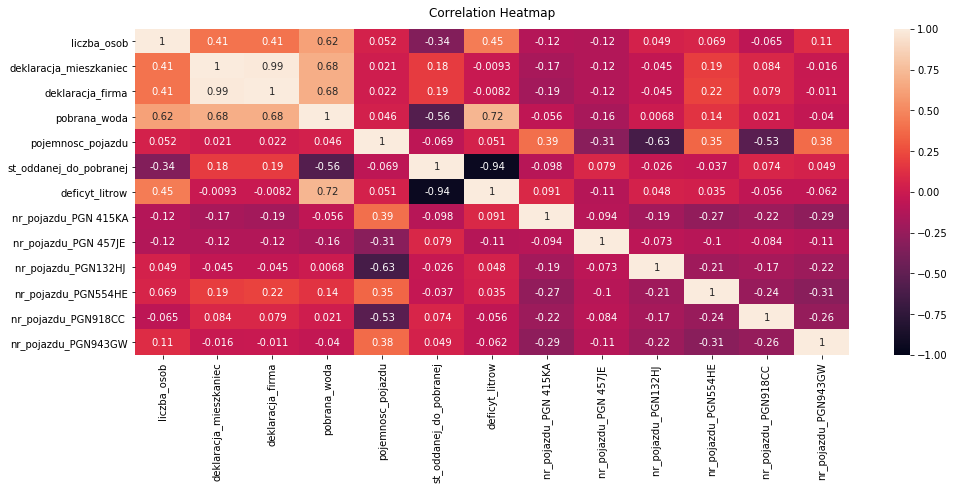

In [137]:
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(df_bez_zbiornikow.corr(), vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

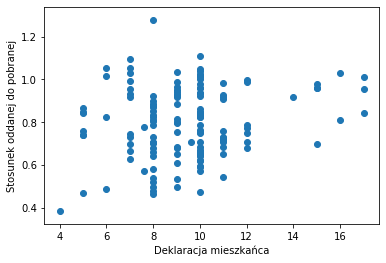

In [138]:
plt.scatter(df_bez_zbiornikow['deklaracja_mieszkaniec'], df_bez_zbiornikow['st_oddanej_do_pobranej'])
plt.xlabel("Deklaracja mieszkańca")
plt.ylabel("Stosunek oddanej do pobranej")
plt.show()

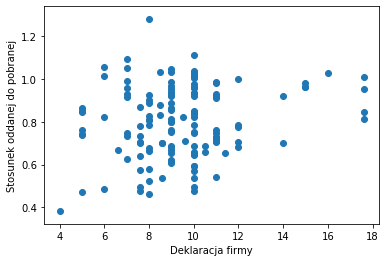

In [139]:
plt.scatter(df_bez_zbiornikow['deklaracja_firma'], df_bez_zbiornikow['st_oddanej_do_pobranej'])
plt.xlabel("Deklaracja firmy")
plt.ylabel("Stosunek oddanej do pobranej")
plt.show()

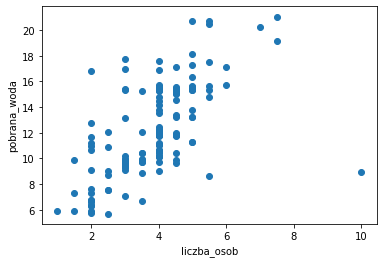

In [140]:
plt.scatter(df_bez_zbiornikow['liczba_osob'], df_bez_zbiornikow['pobrana_woda'])
plt.xlabel("liczba_osob")
plt.ylabel("pobrana_woda")
plt.show()

In [141]:
df_bez_zbiornikow = df_bez_zbiornikow.sort_values(by="deficyt_litrow", ascending = False)

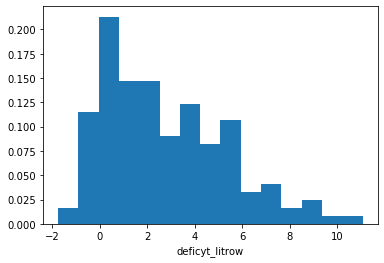

In [142]:
plt.hist(df_bez_zbiornikow["deficyt_litrow"], 15, density=True)
plt.xlabel('deficyt_litrow')
plt.show()

# Analiza ze zbiornikami

In [143]:
df.head()

,nr_pojazdu,adres_licznika,liczba_osob,deklaracja_mieszkaniec,deklaracja_firma,pobrana_woda,pojemnosc_pojazdu
0,PGN 415KA,Zamiejska 16,3.5,4.0,4.0,10.428971,18.0
1,PGN 415KA,Kłeckoska 87,5.5,15.0,14.0,20.712486,18.0
2,PGN 415KA,Trzemeszeńska 7,4.0,9.0,9.0,10.142857,18.0
3,PGN 415KA,Kłeckoska 18,3.0,10.0,9.0,9.078114,18.0
4,PGN 415KA,Roosevelta 9,5.0,10.0,9.0,15.371429,18.0


In [144]:
df_new = df.copy()

df_new['st_oddanej_do_pobranej'] = (df['deklaracja_mieszkaniec'] + 
                                         df['deklaracja_firma'])/2 / \
                                         df['pobrana_woda']

In [145]:
df_new.head()

,nr_pojazdu,adres_licznika,liczba_osob,deklaracja_mieszkaniec,deklaracja_firma,pobrana_woda,pojemnosc_pojazdu,st_oddanej_do_pobranej
0,PGN 415KA,Zamiejska 16,3.5,4.0,4.0,10.428971,18.0,0.383547
1,PGN 415KA,Kłeckoska 87,5.5,15.0,14.0,20.712486,18.0,0.700061
2,PGN 415KA,Trzemeszeńska 7,4.0,9.0,9.0,10.142857,18.0,0.887324
3,PGN 415KA,Kłeckoska 18,3.0,10.0,9.0,9.078114,18.0,1.046473
4,PGN 415KA,Roosevelta 9,5.0,10.0,9.0,15.371429,18.0,0.618030


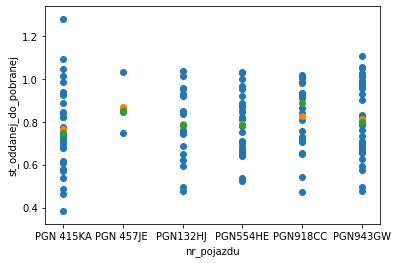

In [146]:
plt.scatter(df_new['nr_pojazdu'], df_new['st_oddanej_do_pobranej'])
#srednie
srednie = df_new.groupby("nr_pojazdu").mean()['st_oddanej_do_pobranej'].to_frame().reset_index()
plt.scatter(srednie['nr_pojazdu'], srednie['st_oddanej_do_pobranej'])

mediany = df_new.groupby("nr_pojazdu").median()['st_oddanej_do_pobranej'].to_frame().reset_index()
plt.scatter(mediany['nr_pojazdu'], mediany['st_oddanej_do_pobranej'])

plt.xlabel("nr_pojazdu")
plt.ylabel("st_oddanej_do_pobranej")
plt.show()

# Preparing data for API

In [147]:
df_for_api = df_new.copy()

In [149]:
# add address
adres = zbiorniki02_raw.drop(['Lp.'], axis = 1)
c = adres.columns
adres = adres.rename(columns = {c[0]: 'nr_zbiornika',
                                  c[1]: 'osoba',
                                  c[2]: 'adres_licznika',
                                  c[3]: 'adres_zamieszkania'})\
                .drop(columns = ['adres_zamieszkania','osoba'])


In [151]:
# calculate means for timeseries
# divide values to account for zeroes
zuzycie_prepered = zuzycie01_raw.copy()

for i in range(145):
    if zuzycie_prepered.iloc[i, 6] != 0:
        for j in range(17):
            temp = zuzycie_prepered.iloc[i, 6 + j * 2]
            zuzycie_prepered.iloc[i, 6 + j * 2] = temp / 2
            zuzycie_prepered.iloc[i, 6 + j * 2 + 1] = temp / 2
    else:
        for j in range(17):
            temp = zuzycie_prepered.iloc[i, 6 + j * 2 + 1]
            zuzycie_prepered.iloc[i, 6 + j * 2] = temp / 2
            zuzycie_prepered.iloc[i, 6 + j * 2 + 1] = temp / 2
    zuzycie_prepered.iloc[i, 40] = zuzycie_prepered.iloc[i, 39]

zuzycie_prepered = zuzycie_prepered.drop(['Lp.'], axis = 1)
c = zuzycie_prepered.columns
zuzycie_prepered = zuzycie_prepered.rename(columns = {c[0]: 'nr_licznika',
                                                      c[1]: 'osoba',
                                                      c[2]: 'adres_licznika',
                                                      c[3]: 'zuzycie_wody',
                                                      c[4]: 'srednie_zuzucie_wody'})
for i in range(5, len(c)):
    zuzycie_prepered.rename(columns = {c[i]: str(i)})

In [152]:
# prepare zuzycie01 for join
zuzycie_prepered = zuzycie_prepered.drop(columns = ['nr_licznika' , 'osoba', 'zuzycie_wody', 'srednie_zuzucie_wody'])
# drop last column
zuzycie_prepered= zuzycie_prepered.iloc[: , :-1]

In [153]:
print(df_for_api.columns)
print(zuzycie_prepered.columns)

Index(['nr_pojazdu', 'adres_licznika', 'liczba_osob', 'deklaracja_mieszkaniec',
       'deklaracja_firma', 'pobrana_woda', 'pojemnosc_pojazdu',
       'st_oddanej_do_pobranej'],
      dtype='object')
Index(['adres_licznika', '2021-11', '2021-10', '2021-9', '2021-8', '2021-7',
       '2021-6', '2021-5', '2021-4', '2021-3', '2021-2', '2021-3.1', '2020-12',
       '2020-11', '2020-10', '2020-9', '2020-8', '2020-7', '2020-6', '2020-5',
       '2020-4', '2020-3', '2020-2', '2020-1', '2019-12', '2019-11', '2019-10',
       '2019-9', '2019-8', '2019-7', '2019-6', '2019-5', '2019-4', '2019-3',
       '2019-2', '2019-1'],
      dtype='object')


In [154]:
print(df_for_api.shape)
print(zuzycie_prepered.shape)

(145, 8)
(145, 36)


In [155]:
df_for_api = df_for_api.set_index(['adres_licznika'])\
            .join(zuzycie_prepered.set_index(['adres_licznika']))\
            .reset_index()

df_for_api.head()

,adres_licznika,nr_pojazdu,liczba_osob,deklaracja_mieszkaniec,deklaracja_firma,pobrana_woda,pojemnosc_pojazdu,st_oddanej_do_pobranej,2021-11,2021-10,...,2019-10,2019-9,2019-8,2019-7,2019-6,2019-5,2019-4,2019-3,2019-2,2019-1
0,Zamiejska 16,PGN 415KA,3.5,4.0,4.0,10.428971,18.0,0.383547,8.2725,8.2725,...,10.5000,10.0,10.0,11.5000,11.5000,10.500,10.500,12.0000,12.0000,12.0000
1,Kłeckoska 87,PGN 415KA,5.5,15.0,14.0,20.712486,18.0,0.700061,19.0000,19.0000,...,20.5245,21.0,21.0,22.0505,22.0505,19.880,19.880,18.0000,18.0000,18.0000
2,Trzemeszeńska 7,PGN 415KA,4.0,9.0,9.0,10.142857,18.0,0.887324,13.0000,13.0000,...,10.5000,12.5,12.5,11.0000,11.0000,9.000,9.000,9.5000,9.5000,9.5000
3,Kłeckoska 18,PGN 415KA,3.0,10.0,9.0,9.078114,18.0,1.046473,12.0000,12.0000,...,9.5000,11.0,11.0,11.0000,11.0000,7.567,7.567,8.4295,8.4295,8.4295
4,Roosevelta 9,PGN 415KA,5.0,10.0,9.0,15.371429,18.0,0.618030,16.5000,16.5000,...,13.5000,13.5,13.5,14.5000,14.5000,15.000,15.000,15.5000,15.5000,15.5000


In [157]:
df_for_api = df_for_api.sort_values(by="st_oddanej_do_pobranej", ascending = False)

In [158]:
df_for_api.head()

,adres_licznika,nr_pojazdu,liczba_osob,deklaracja_mieszkaniec,deklaracja_firma,pobrana_woda,pojemnosc_pojazdu,st_oddanej_do_pobranej,2021-11,2021-10,...,2019-10,2019-9,2019-8,2019-7,2019-6,2019-5,2019-4,2019-3,2019-2,2019-1
6,Żerniki 9,PGN 415KA,2.0,8.0,8.0,6.257143,18.0,1.278539,5.5,5.5,...,6.5,7.0,7.0,6.0,6.0,7.000,7.000,6.0000,6.0000,6.0000
111,Kłeckoska 51,PGN943GW,4.0,10.0,10.0,9.015914,17.6,1.109150,12.0,12.0,...,10.5,12.5,12.5,11.0,11.0,7.567,7.567,8.4295,8.4295,8.4295
14,Pomowska 54,PGN 415KA,2.0,7.0,7.0,6.400000,18.0,1.093750,6.5,6.5,...,6.5,6.0,6.0,6.0,6.0,7.000,7.000,6.0000,6.0000,6.0000
144,Kiszkowska 4,PGN943GW,2.5,6.0,6.0,5.685714,17.6,1.055276,5.5,5.5,...,6.0,5.5,5.5,6.0,6.0,5.500,5.500,5.0000,5.0000,5.0000
133,Makowa 34,PGN943GW,3.5,7.0,7.0,6.657143,17.6,1.051502,6.5,6.5,...,6.5,6.0,6.0,6.0,6.0,6.500,6.500,6.0000,6.0000,6.0000


# Prepare JSON

In [159]:
df_for_api.columns

Index(['adres_licznika', 'nr_pojazdu', 'liczba_osob', 'deklaracja_mieszkaniec',
       'deklaracja_firma', 'pobrana_woda', 'pojemnosc_pojazdu',
       'st_oddanej_do_pobranej', '2021-11', '2021-10', '2021-9', '2021-8',
       '2021-7', '2021-6', '2021-5', '2021-4', '2021-3', '2021-2', '2021-3.1',
       '2020-12', '2020-11', '2020-10', '2020-9', '2020-8', '2020-7', '2020-6',
       '2020-5', '2020-4', '2020-3', '2020-2', '2020-1', '2019-12', '2019-11',
       '2019-10', '2019-9', '2019-8', '2019-7', '2019-6', '2019-5', '2019-4',
       '2019-3', '2019-2', '2019-1'],
      dtype='object')

In [199]:
# uwaga df_for_api musi być zrobione ,zeby funkcja działała - mozna potem zmaknąć całą analizę z góry
# w funkcje w stylu prepare_data
def create_map_datapoints():
    data_dict = {}
    for index, row in df_for_api.iterrows():
        row_dict = {}

        row_dict['nr_zbiornika'] = random.choice("ABCDEFGHIJKL") + str(int(random.uniform(10000, 99999)//1))
        
        if not np.isnan(row['st_oddanej_do_pobranej']): 
            row_dict['st_oddanej_do_pobranej'] = row['st_oddanej_do_pobranej']        

            data_dict[row['adres_licznika']] = row_dict
            
    return data_dict

def create_pobrana_woda_timeseries(adres: str) -> List[dict]:
    graph = []
    graph['name'] = 'pobrana_timeseries'
    graph['title'] = "Pobrana woda na przestrzeni czasu"
    graph['data'] = {}
    
    data = df_for_api[df_for_api['nr_zbiornika'] == nr_zbiornika]
    
    print(data)
    
    

In [200]:
create_map_datapoints()

{'Żerniki 9': {'nr_zbiornika': 'D50442',
  'st_oddanej_do_pobranej': 1.2785388127853876},
 'Kłeckoska 51': {'nr_zbiornika': 'E79012',
  'st_oddanej_do_pobranej': 1.1091498524830703},
 'Pomowska 54': {'nr_zbiornika': 'I46857', 'st_oddanej_do_pobranej': 1.09375},
 'Kiszkowska 4': {'nr_zbiornika': 'K11931',
  'st_oddanej_do_pobranej': 1.055276381909547},
 'Makowa 34': {'nr_zbiornika': 'J86113',
  'st_oddanej_do_pobranej': 1.0515021459227463},
 'Kłeckoska 18': {'nr_zbiornika': 'L93521',
  'st_oddanej_do_pobranej': 1.0464728357682835},
 'Kruszwicka 11': {'nr_zbiornika': 'G17705',
  'st_oddanej_do_pobranej': 1.0385756676557862},
 'Cienista 29': {'nr_zbiornika': 'B73454',
  'st_oddanej_do_pobranej': 1.0327868852459021},
 'Paczkowskiego 6': {'nr_zbiornika': 'C32103',
  'st_oddanej_do_pobranej': 1.0309141215281472},
 'Wiejska 45': {'nr_zbiornika': 'G28381',
  'st_oddanej_do_pobranej': 1.0275229357798146},
 'Żerniki 5': {'nr_zbiornika': 'K86297',
  'st_oddanej_do_pobranej': 1.026392961876833},
 

In [ ]:
create_pobrana_woda_timeseries('Żerniki 9')

In [ ]:
# TODO
#  elif re.search("^20.*$",index): # date
#             date_with_0 = dt.strptime("2019-9", '%Y-%m').strftime('%Y-%m')
#             row_dict[date_with_0] = row[index]

In [ ]:
def deficit_timeseries():
    deklarowane_hist06_raw = pd.read_excel("data/06deklarowane_with_history.xlsx")
    deklarowane_hist06 = deklarowane_hist06_raw.drop(['Lp.'], axis = 1)
    c = deklarowane_hist06.columns
    deklarowane_hist06 = deklarowane_hist06.rename(columns = {c[0]: 'nr_zbiornika',
                                                            c[1]: 'adres_licznika',
                                                            c[2]: 'data_odbioru',
                                                            c[3]: 'deklaracja_mieszkaniec',
                                                            c[4]: 'deklaracja_firma',
                                                            c[5]: 'pobrana_woda',
                                                            c[6]: 'pobrana_woda_ogrodowa',
                                                            c[7]: 'nr_pojazdu'})
    for i in range(8, 14):
        deklarowane06.rename(columns = {c[i]: str(i)})
        
        
    print(deklarowane06)

In [ ]:
deficit_timeseries()